In [ ]:
#@title Imports
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Example to run loss program search."""
import random
import time

from absl import app
from absl import flags

import numpy as np
import pyglove as pg
import tensorflow as tf

import matplotlib.pyplot as plt

from brain_autorl.evolving_rl import evolution_v2
from brain_autorl.evolving_rl import custom_dqn
from brain_autorl.evolving_rl.env_utils import run_train_loop
import brain_autorl.evolving_rl.graph_configs as gconfig
from brain_autorl.evolving_rl.program import build_program
from brain_autorl.evolving_rl.program import InvalidProgramError

In [2]:
#@title Configs
SEED = 1
MAX_TRIALS = 100

POPULATION_SIZE = 20
TOURNAMENT_SIZE = 2
MUTATION_PROB = 0.95

ENV_ID = 'CartPole-v0' # Only 1 env for quick demo
OBJECTIVE_METRIC = 'train/normalized_avg_return_last50'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
#@title Define the loss function search space
(operators, input_nodes, existing_ops, search_space, num_freeze_ops,
  program_length) = gconfig.pre_graph_7_existingdqn_nofreeze()


In [4]:
#@title Set up tuning algorithm
def get_tuning_algorithm(input_nodes, existing_ops, search_space,
                         operators, program_length, num_freeze_ops,
                         adjust_loss_weight):
  """Creates the tuning algorithm for pyglove."""
  graph_spec = evolution_v2.GraphSpec(
      template=pg.template(search_space),
      input_nodes=input_nodes,
      existing_ops=existing_ops,
      program_length=program_length,
      operators=operators,
      adjust_loss_weight=adjust_loss_weight,
  )
  graph_hasher = evolution_v2.GraphHasher(input_nodes)
  graph_generator = evolution_v2.GraphGenerator(
      graph_spec, graph_hasher, SEED)
  graph_mutator = evolution_v2.GraphMutator(
      graph_spec=graph_spec,
      graph_hasher=graph_hasher,
      mutation_probability=MUTATION_PROB,
      num_freeze_ops=num_freeze_ops)

  # Regularized Evolution.
  return evolution_v2.build_regularized_evolution(
      population_size=POPULATION_SIZE,
      tournament_size=TOURNAMENT_SIZE,
      seed=SEED,
      graph_generator=graph_generator,
      graph_mutator=graph_mutator)

generator = get_tuning_algorithm(
    input_nodes,
    existing_ops,
    search_space,
    operators,
    program_length,
    num_freeze_ops,
    adjust_loss_weight=False,
)



In [ ]:
#@title Run evolution
trial_rewards = []
for program_spec, feedback in pg.sample(
    search_space, generator, MAX_TRIALS):  # pytype: disable=wrong-arg-types  # gen-stub-imports

  agent_cls, network_func = custom_dqn.DQN, custom_dqn.make_networks
  loss_program, valid_program = build_program(
      input_nodes, program_spec, operators, check_path_diff=0)

  assert valid_program, 'Invalid program!'

  # If duplicate, then don't run training and just return reward.
  if program_spec.duplicate:
    reward = program_spec.reward
  else:
    train_results = run_train_loop(
        ENV_ID,
        loss_program,
        agent_cls,
        network_func,
        learning_rate=1e-4,
        batch_size=32,
        epsilon_schedule=10000,
        use_priority=False,
        limit_steps=False,
        log_to_xm=False,
        wrapper_version='v3',
        target_update_period=100,
        force_reproducibility=True)
    reward = train_results[OBJECTIVE_METRIC]

  trial_rewards.append(reward)

  feedback.add_measurement(
      reward=float(reward),
      metrics={'reward': reward},
      step=0,
  )
  feedback.done()

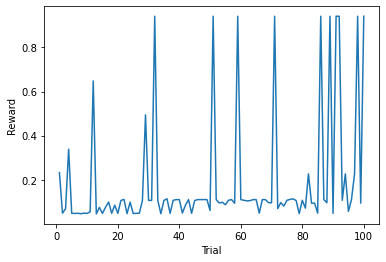

In [7]:
plt.plot(range(1, len(trial_rewards) + 1), trial_rewards)
plt.xlabel('Trial');
plt.ylabel('Reward');